Example notebook from https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html

In [1]:
import dask.distributed
import folium
import folium.plugins
import geopandas as gpd
import shapely.geometry
from IPython.display import HTML, display
import pystac_client

from odc.stac import configure_rio, stac_load


In [2]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [3]:
cfg = {
    "sentinel-s2-l2a-cogs": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
            "SCL": {"data_type": "uint8", "nodata": 0},
            "visual": {"data_type": "uint8", "nodata": 0},
        },
        "aliases": {"red": "B04", "green": "B03", "blue": "B02"},
    },
    "*": {"warnings": "ignore"},
}

In [4]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

from dask.distributed import PipInstall
plugin = PipInstall(packages=["boto3"], pip_options=["--upgrade"])
client.register_worker_plugin(plugin)

client



/opt/openeo-processes-dask/.venv/lib/python3.8/site-packages/distributed/client.py:1309: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.10.final.0 | 3.8.13.final.0 | 3.8.13.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://172.20.0.2:8786' processes=1 threads=12, memory=7.39 GiB>

In [5]:
km2deg = 1.0 / 111
x, y = (113.887, -25.843)  # Center point of a query
r = 100 * km2deg
bbox = (x - r, y - r, x + r, y + r)

catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v0")

query = catalog.search(
    collections=["sentinel-s2-l2a-cogs"], datetime="2021-09-16", limit=100, bbox=bbox
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.get_all_items_as_dict()

Found: 9 datasets


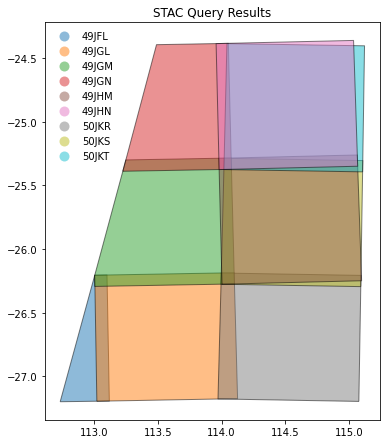

In [6]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
# Compute granule id from components
gdf["granule"] = (
    gdf["sentinel:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["sentinel:latitude_band"]
    + gdf["sentinel:grid_square"]
)

fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

In [7]:
# https://github.com/python-visualization/folium/issues/1501
from branca.element import Figure

fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "sentinel:data_coverage",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

In [8]:
# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"
zoom = 2**5  # overview level 5

xx = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    stac_cfg=cfg,
)
display(xx)

<xarray.Dataset>
Dimensions:      (y: 1099, x: 833, time: 1)
Coordinates:
  * y            (y) float64 -2.797e+06 -2.798e+06 ... -3.148e+06 -3.149e+06
  * x            (x) float64 1.255e+07 1.255e+07 ... 1.282e+07 1.282e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-09-16T02:34:44
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1099, 833), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1099, 833), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1099, 833), meta=np.ndarray>

In [9]:
xx

<xarray.Dataset>
Dimensions:      (y: 1099, x: 833, time: 1)
Coordinates:
  * y            (y) float64 -2.797e+06 -2.798e+06 ... -3.148e+06 -3.149e+06
  * x            (x) float64 1.255e+07 1.255e+07 ... 1.282e+07 1.282e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-09-16T02:34:44
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1099, 833), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1099, 833), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1099, 833), meta=np.ndarray>

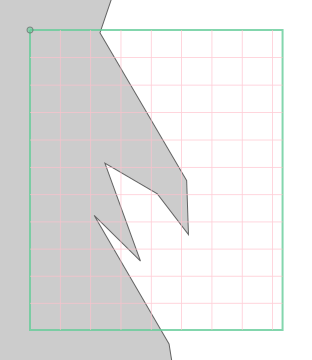

In [10]:
xx.odc.geobox


In [11]:
%%time
xx = xx.compute()

CPU times: user 101 ms, sys: 79.7 ms, total: 181 ms
Wall time: 16 s


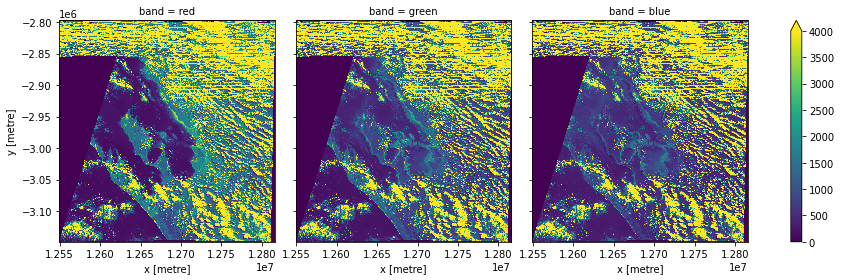

In [13]:
_ = (
    xx.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)

## Load with bounding box

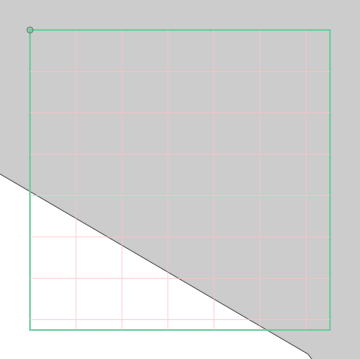

In [14]:
r = 6.5 * km2deg
small_bbox = (x - r, y - r, x + r, y + r)

yy = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    stac_cfg=cfg,
    bbox=small_bbox,
)
display(yy.odc.geobox)

In [15]:
yy = yy.compute()


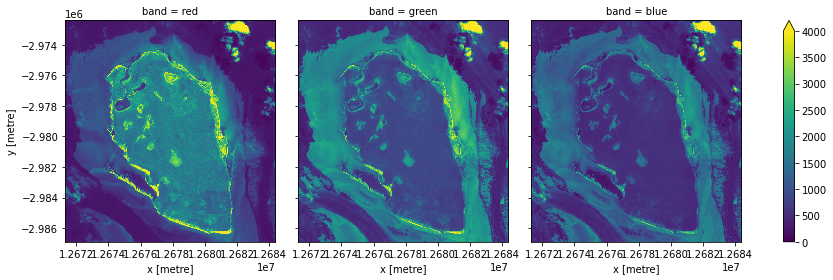

In [16]:
_ = (
    yy.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)